# Machine Translation : English to Hindi
This assignment involves using Seq2Seq (https://arxiv.org/abs/1409.3215) and Attention (https://arxiv.org/abs/1409.0473) Models for Machine Translation.

### Import Requirements

In [1]:
import re
import time
import math
import random
import string
import gensim.downloader
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from io import open
from tqdm import tqdm
from unicodedata import normalize
from torchtext.data.metrics import bleu_score
from __future__ import unicode_literals, print_function, division

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

### Downloading Dataset
We download the following file:
- **MT.zip** : The dataset provided for the assignment

In [2]:
!wget --no-check-certificate -q -nc 'https://docs.google.com/uc?export=download&id=1bEK6RCdnXIqg8JGrJIMvDaAM-baalGwt' -O MT.zip
!unzip -n MT.zip

Archive:  MT.zip


The maximum length of english sentence in the dataset is set to be 150. Apart from this we can either choose to train or load pre-trained models for our models. Set `TRAIN` to `True` or `False` for training or loading the Seq2Seq model respectively. Similarly, `TRAIN_ATTN` for Attention model.

In [3]:
MAX_LENGTH = 150
EMBEDDING_DIM = 300
TRAIN = True
TRAIN_ATTN = True

### Defining the Language Class

In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### Processing the data

In [5]:
def clean_text(text):
    text = text.replace(u',','')
    text = text.replace(u'"','')
    text = text.replace(u'"','')
    text = text.replace(u"‘‘",'')
    text = text.replace(u"’’",'')
    text = text.replace(u"''",'')
    text = text.replace(u"।",'')
    text=text.replace(u',','')
    text=text.replace(u'"','')
    text=text.replace(u'(','')
    text=text.replace(u')','')
    text=text.replace(u'"','')
    text=text.replace(u':','')
    text=text.replace(u"'",'')
    text=text.replace(u"‘‘",'')
    text=text.replace(u"’’",'')
    text=text.replace(u"''",'')
    text=text.replace(u".",'')
    text=text.replace(u"-",'')
    text=text.replace(u"।",'')
    text=text.replace(u"?",'')
    text=text.replace(u"\\",'')
    text=text.replace(u"_",'')
    text=text.replace("'", "")
    text=text.replace('"', "")
    text= re.sub("'", '', text)
    text= re.sub("’", '', text)
    text=re.sub('[0-9+\-*/.%]', '', text)
    text=text.strip()
    text=re.sub(' +', ' ',text)
    exclude = set(string.punctuation)
    text= ''.join(ch for ch in text if ch not in exclude)
    return text

In [6]:
def pre_process_english_sentence(line):
    line = line.lower()
    line = clean_text(line)
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    line = normalize('NFD', line).encode('ascii', 'ignore')
    line = line.decode('UTF-8')
    line = line.split()
    line = [re_print.sub('', w) for w in line]
    line = [word for word in line if word.isalpha()]
    line = ' '.join(line)
    return line

def pre_process_hindi_sentence(line):
    line=re.sub('[a-zA-Z]', '', line)
    line = clean_text(line)
    exclude = set(string.punctuation)
    remove_digits = str.maketrans('', '', string.digits)
    line = re.sub("'", '', line)
    line = ''.join(ch for ch in line if ch not in exclude)
    line = line.translate(remove_digits)
    line = re.sub("[२३०८१५७९४६]", "", line)
    line = line.strip()
    line = re.sub(" +", " ", line)
    return (line)

In [7]:
def normalizeString(s, lang):
    if lang == 'english':
        s = pre_process_english_sentence(s)
    elif lang == 'hindi':
        s = pre_process_hindi_sentence(s)
    
    return s

In [8]:
def readLangs(lang1, lang2):
    print("Reading lines...")

    # Read the file and split into lines
    lang1_lines_train = open('./MT/%s.train' % (lang1), encoding='utf-8').\
        read().strip().split('\n')

    lang2_lines_train = open('./MT/%s.train' % (lang2), encoding='utf-8').\
        read().strip().split('\n')

    lang1_lines_test = open('./MT/%s.test' % (lang1), encoding='utf-8').\
        read().strip().split('\n')

    lang2_lines_test = open('./MT/%s.test' % (lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs_train = [[normalizeString(lang1_lines_train[idx], lang1), normalizeString(lang2_lines_train[idx], lang2)] \
        for idx, l in enumerate(lang1_lines_train)]

    pairs_test = [[normalizeString(lang1_lines_test[idx], lang1), normalizeString(lang2_lines_test[idx], lang2)] \
        for idx, l in enumerate(lang1_lines_test)]

    # Make Lang instances
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang, pairs_train, pairs_test

In [9]:
def prepareData(lang1, lang2):
    input_lang, output_lang, pairs_train, pairs_test = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % (len(pairs_train) + len(pairs_test)))
    # pairs = filterPairs(pairs)
    # print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs_train:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    for pair in pairs_test:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs_train, pairs_test


input_lang, output_lang, pairs_train, pairs_test = prepareData('english', 'hindi')
print(random.choice(pairs_train))

Reading lines...
Read 52507 sentence pairs
Counting words...
Counted words:
english 10307
hindi 10764
['reserve left', 'अतिरिक्त बाकीः']


### Loading Word2Vec Embeddings
We load the pretrained word2vec embeddings using gensim

In [10]:
wv = gensim.downloader.load('word2vec-google-news-300')

In [11]:
vocabulary = input_lang.word2index.items()
word2vec_weights = np.zeros((input_lang.n_words, EMBEDDING_DIM), dtype=np.float32)

count = 0

for i, (word, idx) in enumerate(vocabulary):
    try:
        word2vec_weights[idx] = wv[word]
    except:
        word2vec_weights[idx] = np.random.random(EMBEDDING_DIM)
        count += 1

print(f'{count} words were randomly allocated embedding weights.')

1518 words were randomly allocated embedding weights.


### The Encoder

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # self.embedding = nn.Embedding(input_size, hidden_size)
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(word2vec_weights))
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### The Decoder for Seq2Seq Model

In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### The Decoder for Attention Model

In [14]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### Training Functions

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [16]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, attention=False, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            if attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            if attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [17]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [18]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.006, attention=False):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs_train))
                      for i in range(n_iters)]
    criterion = nn.CrossEntropyLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, attention=attention)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

In [19]:
plt.switch_backend('agg')

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)

### Evaluation Functions

In [20]:
def evaluate(encoder, decoder, sentence, attention=False, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            if attention:
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                decoder_attentions[di] = decoder_attention.data
            else:
                decoder_output, decoder_hidden = decoder(
                    decoder_input, decoder_hidden)
            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()
        
        if decoded_words[-1] == '<EOS>':
            decoded_words.pop()
        
        if attention:
            return decoded_words, decoder_attentions[:di + 1]
        
        return decoded_words

In [21]:
def evaluateRandomly(encoder, decoder, attention=False, n=10):
    for i in range(n):
        pair = random.choice(pairs_train)
        print('>', pair[0])
        print('=', pair[1])
        if attention:
            output_words, attentions = evaluate(encoder, decoder, pair[0], attention=attention)
        else:
            output_words = evaluate(encoder, decoder, pair[0], attention=attention)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

### The Models

In [22]:
hidden_size = 300
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)
attn_encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

### Training/Loading the Seq2Seq Model

3m 35s (- 68m 14s) (25000 5%) 4.4564
6m 58s (- 62m 46s) (50000 10%) 3.9758
10m 42s (- 60m 38s) (75000 15%) 3.3391
14m 40s (- 58m 43s) (100000 20%) 2.6857
19m 3s (- 57m 11s) (125000 25%) 2.1222
23m 30s (- 54m 50s) (150000 30%) 1.6609
27m 59s (- 51m 59s) (175000 35%) 1.2784
32m 29s (- 48m 43s) (200000 40%) 1.0227
36m 59s (- 45m 12s) (225000 45%) 0.8288
41m 31s (- 41m 31s) (250000 50%) 0.7097
46m 4s (- 37m 41s) (275000 55%) 0.6155
50m 41s (- 33m 47s) (300000 60%) 0.5399
55m 15s (- 29m 45s) (325000 65%) 0.4897
59m 48s (- 25m 38s) (350000 70%) 0.4416
64m 22s (- 21m 27s) (375000 75%) 0.4152
68m 51s (- 17m 12s) (400000 80%) 0.3944
73m 29s (- 12m 58s) (425000 85%) 0.3654
78m 5s (- 8m 40s) (450000 90%) 0.3450
82m 40s (- 4m 21s) (475000 95%) 0.3349
87m 20s (- 0m 0s) (500000 100%) 0.3204


<Figure size 432x288 with 0 Axes>

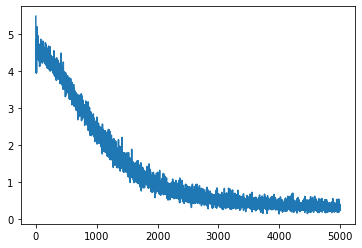

In [ ]:
%matplotlib inline

if TRAIN:
    trainIters(encoder1, decoder1, 500000, print_every=25000)
    torch.save(encoder1.state_dict(), 'encoder.dict')
    torch.save(decoder1.state_dict(), 'decoder.dict')
else:
    encoder1.load_state_dict(torch.load('encoder.dict'))
    decoder1.load_state_dict(torch.load('decoder.dict'))

### Training/Loading the Attention Model

8m 36s (- 163m 38s) (25000 5%) 4.4537
15m 7s (- 136m 9s) (50000 10%) 3.8896
21m 47s (- 123m 31s) (75000 15%) 3.2689
28m 30s (- 114m 0s) (100000 20%) 2.6277
35m 22s (- 106m 7s) (125000 25%) 2.1120
42m 14s (- 98m 32s) (150000 30%) 1.6399
49m 13s (- 91m 25s) (175000 35%) 1.3436
56m 17s (- 84m 26s) (200000 40%) 1.0708
63m 24s (- 77m 29s) (225000 45%) 0.9166
70m 34s (- 70m 34s) (250000 50%) 0.7935
77m 38s (- 63m 31s) (275000 55%) 0.6935
84m 32s (- 56m 21s) (300000 60%) 0.6229
91m 22s (- 49m 12s) (325000 65%) 0.5736
98m 15s (- 42m 6s) (350000 70%) 0.5271
105m 14s (- 35m 4s) (375000 75%) 0.4900
112m 10s (- 28m 2s) (400000 80%) 0.4559
119m 5s (- 21m 0s) (425000 85%) 0.4470
125m 55s (- 13m 59s) (450000 90%) 0.4311
132m 51s (- 6m 59s) (475000 95%) 0.4172
139m 47s (- 0m 0s) (500000 100%) 0.4035


<Figure size 432x288 with 0 Axes>

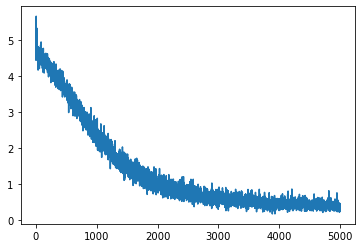

In [ ]:
%matplotlib inline

if TRAIN_ATTN:
    trainIters(attn_encoder1, attn_decoder1, 500000, print_every=25000, attention=True)
    torch.save(attn_encoder1.state_dict(), 'encoder_attn.dict')
    torch.save(attn_decoder1.state_dict(), 'decoder_attn.dict')
else:
    attn_encoder1.load_state_dict(torch.load('encoder_attn.dict'))
    attn_decoder1.load_state_dict(torch.load('decoder_attn.dict'))

### Evaluating the Models on random sentences

In [25]:
evaluateRandomly(encoder1, decoder1, attention=False, n=5)

> enable h tunneling
= टनलिंग सक्षम करें
< टनलिंग सक्षम करें

> add an ekiga net account
= खाता जोड़ें
< खाता जोड़ें

> the number of photos to take in a single burst
= एकल बर्स्ट में लेने के लिए तस्वीर की संख्या
< एकल बर्स्ट में लेने के लिए तस्वीर की संख्या

> could not find a valid project backend for the given directory s please select a different directory or try upgrading to a newer version of anjuta
= नहीं के लिए निर्देशिका से कृपया निर्देशिका या को संस्करण का
< नहीं के लिए निर्देशिका से कृपया निर्देशिका या को संस्करण का

> move a onto the nine of spades
= को एक हुकुम का नहला पर ले जाएँ
< को हुकुम का नहला पर ले जाएँ



In [26]:
evaluateRandomly(attn_encoder1, attn_decoder1, attention=True, n=5)

> convert eol to crlf
= बदलें को
< बदलें को

> remove the eights
= अट्ठा मिटाएँ
< अट्ठा मिटाएँ

> axis of rotation
= घुमाव का अक्ष
< घुमाव का अक्ष

> mailbox files to apply
= डाक डिब्बा फ़ाइल कोः
< डाक डिब्बा फ़ाइल कोः

> deal another round
= एक दौर और चलें
< एक दौर और चलें



['छवि', 'फ़ाइल', 'का', 'स्थान']


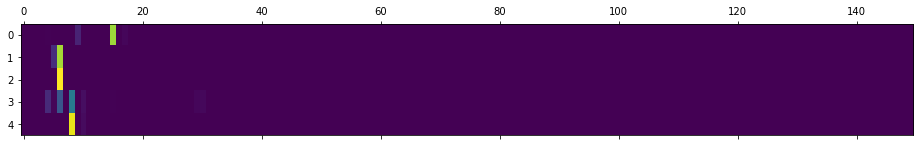

In [27]:
%matplotlib inline

output_words, attentions = evaluate(
    attn_encoder1, attn_decoder1, "location for image file", attention=True)
print(output_words)
plt.matshow(attentions.numpy(), aspect='auto')

In [28]:
def get_test_data(attention=False):
    if attention:
        pairs_t = random.sample(pairs_train, 2400)
        pairs_t.extend(random.sample(pairs_test, 107))
    else:
        pairs_t = random.sample(pairs_train, 2300)
        pairs_t.extend(random.sample(pairs_test, 207))
    return pairs_t

In [29]:
pairs_ta = get_test_data(attention=True)
pairs_t = get_test_data()

x_test = [pair[0] for pair in pairs_t]
y_test = [pair[1].split() for pair in pairs_t]
x_test_a = [pair[0] for pair in pairs_ta]
y_test_a = [pair[1].split() for pair in pairs_ta]

predicted_test = []
reference_test = []
predicted_test_attn = []
reference_test_attn = []

for senx, seny, senxa, senya in tqdm(zip(x_test, y_test, x_test_a, y_test_a), total=len(x_test)):
    # With Attention
    output_words_attn, attentions = evaluate(
        attn_encoder1, attn_decoder1, senxa, attention=True)
    # Without Attention
    output_words = evaluate(
        encoder1, decoder1, senx, attention=False)
    if len(senx) > 0 and len(seny) > 0:
        predicted_test.append(output_words)
        reference_test.append([seny])
    if len(senxa) > 0 and len(senya) > 0:
        predicted_test_attn.append(output_words_attn)
        reference_test_attn.append([senya])

print(f'Number of Test Samples Evaluated on Seq2Seq Model: {len(predicted_test)}')
print(f'Number of Test Samples Evaluated on Attention Model: {len(predicted_test)}')

100%|██████████| 2507/2507 [00:15<00:00, 162.06it/s]

Number of Test Samples Evaluated on Seq2Seq Model: 2436
Number of Test Samples Evaluated on Attention Model: 2436


In [30]:
print(f'BLEU Score for Normal Decoder: {bleu_score(predicted_test, reference_test)}')
print(f'BLEU Score for Attention Decoder: {bleu_score(predicted_test_attn, reference_test_attn)}')

BLEU Score for Normal Decoder: 0.5530443839910893
BLEU Score for Attention Decoder: 0.6511479665068118
